# Ensemble Models for Gold Price Forecasting

## Introduction

This notebook explores the use of ensemble models to forecast gold prices based on historical data. Ensemble methods combine multiple learning algorithms to achieve better predictive performance than any single model. In this analysis, we implement several ensemble techniques, including **Random Forest**, **Gradient Boosting**, **AdaBoost**, **Extra Trees**, and **XGBoost**.

The process begins with hyperparameter tuning for each ensemble model using **RandomizedSearchCV**, optimizing key parameters to enhance model accuracy. Once the best models are identified, we generate meta-predictions from their outputs, which are then utilized to train a final stacking model—**XGBoost**.

Through this approach, we aim to leverage the strengths of individual models to improve overall forecasting accuracy. We also evaluate the performance of the stacking model on a test dataset and analyze its effectiveness in predicting future gold prices, including the assessment of trading strategies based on the model's predictions.

## Importing Libraries and Packages

In [1]:
# Import essential libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np

# Import tools for model selection and hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Import various ensemble regressors for building the ensemble models
from sklearn.ensemble import (
    AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
)
from xgboost import XGBRegressor  # Import XGBoost regressor, a popular gradient boosting model

# Import Plotly for data visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import evaluation metrics for model performance
from sklearn.metrics import r2_score, mean_squared_error

# Suppress warning messages for cleaner output
import warnings
warnings.filterwarnings('ignore')

## Data Loading 

The dataset used in this notebook consists of historical gold prices from the GLD ETF, along with several engineered features created in the `dataprep.py` script. Key features include:

+ **Momentum Indicators** : Various moving averages (e.g., MA3, MA9) and exponential moving averages (e.g., EMA_8).
+ **Volatility Measures** : Rolling standard deviations (e.g., STD_5).
+ **Return Metrics** : Cumulative percentage changes over short periods (e.g., PCT_3).
+ **Additional Indicators** : Related financial instruments such as GDX (Gold Miners ETF), USO (Oil Fund ETF), 10-Year Treasury Yield, and the US Dollar Index (DXY).

This prepared data will be used to build and evaluate predictive models.

In [2]:
# Load the dataset, using 'Date' as the index and parsing the dates correctly
data = pd.read_csv('gold_data.csv', index_col='Date', parse_dates=True)

# Create a list of feature names, selecting all columns starting from the 6th column onward
feature_list = data.columns.tolist()[5:]

## Data Preparation

Before we begin training our models, we need to prepare the data by defining the target variable and splitting the dataset into training and testing sets. We set the target variable as the next day's closing price by shifting the 'Close' column by one day. This allows our models to learn from past prices to predict future prices. We also split the data into training and testing sets, with data prior to 2022 used for training and data after 2022 reserved for testing. Additionally, we perform an 80-20 split within the training data to create a validation set.

In [3]:
# Define the target variable as the next day's closing price by shifting 'Close' column
data['next_day_price'] = data['Close'].shift(-1)

# Remove any rows with missing values resulting from the shift
data = data.dropna()

# Split the data into training features (X) and target variable (y) for dates before 2022
X = data.loc[data.index < '2022-01-01', feature_list]
y = data.loc[data.index < '2022-01-01', 'next_day_price']

# Set aside data after 2022 for testing
test = data[data.index >= '2022-01-01']

In [4]:
# Calculate the 80-20 split point for the training and testing sets
split_point = int(len(X) * 0.8)

# Split the features and target into training (80%) and validation (20%) sets
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print("Training Set Size:", X_train.shape, y_train.shape)
print("Testing Set Size:", X_test.shape, y_test.shape)

Training Set Size: (2799, 22) (2799,)
Testing Set Size: (700, 22) (700,)


## Model Implementation

### Base Models Selection

To optimize the performance of our ensemble models, we employ RandomizedSearchCV to perform hyperparameter tuning. By defining parameter grids for each model, we enable the search for the most effective configurations, such as the number of estimators, learning rates, and tree depths. These configurations help improve the predictive power of the models, allowing us to select the best-performing combination of hyperparameters. The hyperparameter search is conducted using cross-validation to ensure the models generalize well and are not overfitting to the training data.

In [6]:
# Define parameter grids for hyperparameter tuning for each ensemble model
param_grid_rf = {'n_estimators': [50, 300], 'max_depth': [1, 20]}  # Random Forest
param_grid_gb = {'n_estimators': [50, 300], 'learning_rate': [0.01, 0.1]}  # Gradient Boosting
param_grid_bagging = {'n_estimators': [50, 300]}  # Bagging
param_grid_ada = {'n_estimators': [50, 300]}  # AdaBoost
param_grid_extra = {'n_estimators': [50, 300]}  # Extra Trees
param_grid_xgb = {  # XGBoost with additional regularization parameters
    'n_estimators': [50, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 10],
    'lambda': [0.1, 1.0, 10.0],  # L2 regularization
    'alpha': [0.1, 1.0, 10.0]  # L1 regularization
}

# Set up randomized search with cross-validation (cv=5) for each model
search_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, n_jobs=-1)
search_gb = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, n_jobs=-1)
search_bagging = RandomizedSearchCV(BaggingRegressor(random_state=42), param_grid_bagging, cv=5, n_jobs=-1)
search_ada = RandomizedSearchCV(AdaBoostRegressor(random_state=42), param_grid_ada, cv=5, n_jobs=-1)
search_extra = RandomizedSearchCV(ExtraTreesRegressor(random_state=42), param_grid_extra, cv=5, n_jobs=-1)
search_xgb = RandomizedSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, n_jobs=-1)

In [7]:
# Fit each ensemble model using the training data and perform hyperparameter tuning with RandomizedSearchCV
search_rf.fit(X, y)
search_gb.fit(X, y)
search_bagging.fit(X, y)
search_ada.fit(X, y)
search_extra.fit(X, y)

RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42),
                   n_jobs=-1, param_distributions={'n_estimators': [50, 300]})

After conducting hyperparameter tuning for each ensemble model, we now gather the best estimators identified during the tuning process. Each model has been optimized to enhance its performance, and retrieving the best estimator allows us to utilize the configurations that yielded the most accurate predictions. By compiling these optimized models into a list, we set the stage for creating a stacking ensemble, which combines the strengths of each individual model to improve overall predictive performance on the test data.

In [8]:
# Store the best estimators from each model after hyperparameter tuning
base_models = [
    ('ada', search_ada.best_estimator_),  # Best AdaBoost model
    ('bagging', search_bagging.best_estimator_),  # Best Bagging model
    ('extra', search_extra.best_estimator_),  # Best Extra Trees model
    ('gboost', search_gb.best_estimator_),  # Best Gradient Boosting model
    ('rf', search_rf.best_estimator_),  # Best Random Forest model
]

### Generating Predictions with Base Models

With the best estimators of each ensemble model collected, we proceed to train these models on the training data. This step involves fitting each base model to the entire dataset, allowing them to learn from the available features. After training, we generate predictions for both the training set and the test set. These predictions will serve as the input for our stacking ensemble model, where the output of each base model is combined to improve predictive accuracy. By systematically storing these predictions in a structured manner, we create a meta-feature set that captures the performance of each model.

In [9]:
# Train each base model on the training data and generate predictions for both the training and test sets
train_meta = np.zeros((X.shape[0], len(base_models)))  # Initialize matrix to store training predictions
test_meta = np.zeros((test.shape[0], len(base_models)))  # Initialize matrix to store test predictions

# Loop through each base model, fit it to the training data, and store the predictions
for i, (name, model) in enumerate(base_models):
    model.fit(X, y)  # Train the model
    train_meta[:, i] = model.predict(X)  # Predict on the training data and store the results
    test_meta[:, i] = model.predict(test[feature_list])  # Predict on the test data and store the results

### Stacking Model

After generating meta-predictions from our base models, we move on to train the final stacking model using **XGBoost**. This model leverages the predictions from the ensemble of base models as input features, allowing it to learn how to combine their outputs effectively. By fitting XGBoost to the stacked predictions, we aim to enhance the overall performance and robustness of our forecasting system. Additionally, we will utilize hyperparameter tuning to optimize the XGBoost model, ensuring that it achieves the best possible predictive accuracy on the target variable.

In [10]:
# Train the final stacking model using XGBoost on the meta-predictions generated by the base models
search_xgb.fit(train_meta, y)  # Fit XGBoost to the meta-features (stacked predictions)
best_xgb = search_xgb.best_estimator_  # Retrieve the best XGBoost model after tuning

### Ensemble Model Performance

With the final stacking model trained using the meta-predictions from our base models, we proceed to evaluate its performance on the test set. By using the best XGBoost model, we generate predictions based on the stacked predictions of the base models. Subsequently, we calculate the R² score to quantify how well the model explains the variance in the actual gold prices. This evaluation will provide insight into the effectiveness of our ensemble approach in capturing the underlying patterns in the data.

In [11]:
# Use the final stacking model (XGBoost) to make predictions on the test set
y_pred = best_xgb.predict(test_meta)

# Calculate and print the R² score to evaluate the performance of the stacking model on the test set
r2 = r2_score(test['next_day_price'], y_pred)
print("R² Score on Test Set:", r2)

R² Score on Test Set: 0.33165901878642


The stacking model achieved an R² score of 0.3317 on the test set, indicating that approximately 33.2% of the variance in the gold prices is explained by the model. While this score suggests some level of predictive ability, it also highlights that there may be significant factors influencing gold prices that are not captured by the current ensemble of models.

In [12]:
# Plot actual vs predicted prices
fig = go.Figure()

# Add actual prices trace
fig.add_trace(go.Scatter(
    x=test.index,  # Use the last indices for the test set
    y=test['next_day_price'],
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue'),
))

# Add predicted prices trace
fig.add_trace(go.Scatter(
    x=test.index,  # Use the last indices for the test set
    y=y_pred,
    mode='lines',
    name='Predicted Prices',
    line=dict(color='red', dash='dash')
))

# Customize the layout
fig.update_layout(
    title='Actual vs Predicted Prices',
    xaxis_title='Date',
    yaxis_title='Gold Prices (USD)',
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True, 
        gridcolor='lightgrey',
        tickformat='%Y-%m',  # Format dates to show year and month
        rangeslider=dict(visible=True)  # Add range slider for zooming
    ),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    font=dict(size=12),
    legend=dict(x=0, y=1.1, orientation='h'),
)

# Show the plot
fig.show()

## Trading Strategy Simulation

In this section, we begin implementing a simple trading strategy that leverages the model's forecasted prices. By comparing the model's predicted next-day prices with the actual prices, we generate signals that can guide potential trading actions, such as going long (buy) or holding a position.

The price indicator is calculated based on the difference between the predicted and actual next-day prices. This indicator serves as the core of our trading strategy, providing actionable insights into whether the model anticipates upward or downward price movements.

Once the trading signals are generated, we will later evaluate the performance of this strategy by analyzing some known metrics.

In [13]:
# Create a DataFrame
gold = pd.DataFrame()

# Store actual and predicted prices, along with daily returns
gold['Price'] = test['Close']  # Actual closing price
gold['Predicted_price_next_day'] = y_pred  # Model's predicted price for the next day
gold['Actual_price_next_day'] = test['next_day_price']  # Actual price for the next day
gold['Daily Returns'] = gold['Price'].pct_change()  # Calculate daily returns

# Generate a long signal based on price indicators
gold['Price_indicator'] = (test['next_day_price'] - y_pred) / test['next_day_price'] * 10

# Display a sample of the data signals
gold.sample(5)

,Price,Predicted_price_next_day,Actual_price_next_day,Daily Returns,Price_indicator
Date,,,,,
2022-05-09,172.880005,171.517670,171.419998,-0.014479,-0.005698
2022-07-01,168.320007,168.177338,164.750000,-0.000831,-0.208033
2022-02-03,168.600006,168.020554,168.860001,-0.001421,0.049713
2023-02-07,173.979996,173.058945,174.410004,0.000920,0.077465
2022-06-07,172.940002,171.166382,172.779999,0.006518,0.093391


In this trading strategy, we define dynamic thresholds to classify the model's price predictions as undervalued or overvalued. These thresholds help generate trading signals based on the forecasted price movements:

+ **Lower Threshold** (-0.4): When the price indicator falls below this level, the asset is considered undervalued, signaling a potential buy opportunity.
+ **Upper Threshold** (0.8): When the price indicator rises above this level, the asset is considered overvalued, signaling a potential sell or hold decision.

These specific threshold values are not arbitrary. They were chosen with the goal of maximizing the Sharpe ratio, which measures risk-adjusted returns, while also minimizing maximum drawdown, a metric that reflects the largest loss from a peak to a trough in the strategy's performance. This optimization helps ensure that the trading strategy not only delivers profitable returns but also manages risk effectively.

In [14]:
# Plot price and indicator
fig = make_subplots()

# Add the Price Indicator line to the plot
fig.add_trace(go.Scatter(x=gold.index, y=gold['Price_indicator'], mode='lines', name='Price Indicator'))

# Define dynamic thresholds for indicators
lower_threshold = -0.4  # Threshold for Undervalued
upper_threshold = 1.0   # Threshold for Overvalued

# Add horizontal lines for Neutral, Undervalued, and Overvalued indicators
fig.add_trace(go.Scatter(x=[gold.index.min(), gold.index.max()], y=[0, 0], 
                         mode='lines', line=dict(color='black', dash='dash'), name='Neutral'))

fig.add_trace(go.Scatter(x=[gold.index.min(), gold.index.max()], y=[lower_threshold, lower_threshold], 
                         mode='lines', line=dict(color='green', dash='dash'), name='Undervalued'))

fig.add_trace(go.Scatter(x=[gold.index.min(), gold.index.max()], y=[upper_threshold, upper_threshold], 
                         mode='lines', line=dict(color='red', dash='dash'), name='Overvalued'))

# Update layout with titles and dimensions
fig.update_layout(
    title='Price Indicator Plot',
    xaxis_title='Date',
    yaxis_title='Price Indicator',
    legend_title='Legend',
    autosize=False,
    width=1100,
    height=500
)

# Display the plot
fig.show()

In [32]:
# Implement a Trading Strategy Based on the Price Indicator

# Initialize trading signal and position columns
gold['Trading Signal'] = 0.0  # No initial signals
gold['Position'] = 0  # 1 for long, -1 for short, 0 for no position
gold['Strategy Returns'] = 0.0  # Initialize returns

# Generate trading signals based on price indicators
gold.loc[gold['Price_indicator'] > 0.8, 'Trading Signal'] = -1  # Short signal
gold.loc[gold['Price_indicator'] < -0.4, 'Trading Signal'] = 1  # Long signal

# Shift signals to create positions for the next day
gold['Position'] = gold['Trading Signal'].shift(1)

# Calculate strategy returns based on positions
gold.loc[gold['Position'] == 1, 'Strategy Returns'] = gold['Daily Returns']  # Returns for long positions
gold.loc[gold['Position'] == -1, 'Strategy Returns'] = -gold['Daily Returns']  # Returns for short positions

# Calculate performance metrics: Sharpe ratio and maximum drawdown
strategy_returns = gold['Strategy Returns'].dropna()  # Drop NaN values
sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized Sharpe ratio
max_drawdown = np.max(np.maximum.accumulate(strategy_returns) - strategy_returns)  # Maximum drawdown calculation

# Print the calculated performance metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")

Sharpe Ratio: -0.68
Maximum Drawdown: 0.06


The trading strategy based on the stacking model's predictions yielded a Sharpe Ratio of -0.68, indicating that the strategy has underperformed relative to a risk-free investment when considering the level of risk taken. A negative Sharpe Ratio suggests that the returns generated do not justify the risk involved, highlighting the need for reevaluation of the trading signals or model outputs. Additionally, the Maximum Drawdown of 0.06 (or 6%) reflects the largest observed decline from a peak to a trough during the strategy's performance. While this drawdown is manageable, the negative Sharpe Ratio raises concerns about the overall viability of the strategy.

In [30]:
# Plot the strategy returns and equity curve
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# First subplot: Gold ETF Price and Strategy Returns
fig.add_trace(go.Scatter(x=gold.index, y=gold['Price'], mode='lines', name='Gold ETF Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=gold.index, y=gold['Price'] * (1 + gold['Strategy Returns'].cumsum().fillna(0)),
                                                          mode='lines', name='Strategy Returns'), row=1, col=1)

# Second subplot: Trading Signal
fig.add_trace(go.Scatter(x=gold.index, y=gold['Trading Signal'], mode='lines', name='Trading Signal'), row=2, col=1)

# Add a horizontal line at y=0 for the Trading Signal
fig.add_trace(go.Scatter(x=gold.index, y=[0,0], 
                         mode='lines', line=dict(color='red', dash='dash'), name='Zero Line'), row=2, col=1)

# Update layout
fig.update_layout(
    title='Gold ETF Price, Strategy Returns, & Trading Signal',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    autosize=False,
    width=1100,
    height=600
)

# Update y-axis titles for each subplot
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Trading Signal", row=2, col=1)

# Show the plot
fig.show()

In [31]:
initial_investment = gold['Price'][0]
# Calculate the equity curve based on cumulative strategy returns
equity_curve = gold['Price'] * (1 + gold['Strategy Returns'].cumsum().fillna(0)) / initial_investment * 100

# Create the Plotly figure
fig = go.Figure()

# Add the Equity Curve line to the figure
fig.add_trace(go.Scatter(x=gold.index, y=equity_curve, mode='lines', name='Equity Curve (%)'))

# Update layout for titles and labels
fig.update_layout(
    title='Equity Curve (%)',  # Title of the plot
    xaxis_title='Date',  # X-axis label
    yaxis_title='Equity (%)',  # Y-axis label
    legend_title='Legend',  # Legend title
    autosize=False,  # Disable autosizing
    width=1100,  # Set figure width
    height=600,  # Set figure height
    xaxis=dict(
        showgrid=True,  # Show grid lines on the x-axis
        gridcolor='lightgrey',  # Set grid color
        tickformat='%Y-%m',  # Format dates to show year and month
        rangeslider=dict(visible=True))  # Add a range slider for zooming
)

# Show the plot
fig.show()

                    Strategy
------------------  ----------
Start Period        2022-01-03
End Period          2024-07-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   16.07%
CAGR﹪              4.08%

Sharpe              0.51
Prob. Sharpe Ratio  79.49%
Sortino             0.77
Sortino/√2          0.54
Omega               1.09

Max Drawdown        -21.03%
Longest DD Days     632

Gain/Pain Ratio     0.09
Gain/Pain (1M)      0.49

Payoff Ratio        1.09
Profit Factor       1.09
Common Sense Ratio  1.21
CPC Index           0.6
Tail Ratio          1.1
Outlier Win Ratio   3.79
Outlier Loss Ratio  3.34

MTD                 -0.51%
3M                  -0.75%
6M                  3.75%
YTD                 2.2%
1Y                  7.44%
3Y (ann.)           4.08%
5Y (ann.)           4.08%
10Y (ann.)          4.08%
All-time (ann.)     4.08%

Avg. Drawdown       -3.54%
Avg. Drawdown Days  75
Recovery Factor     0.81
Ulcer Index         0.09
Serenity Index      0.1


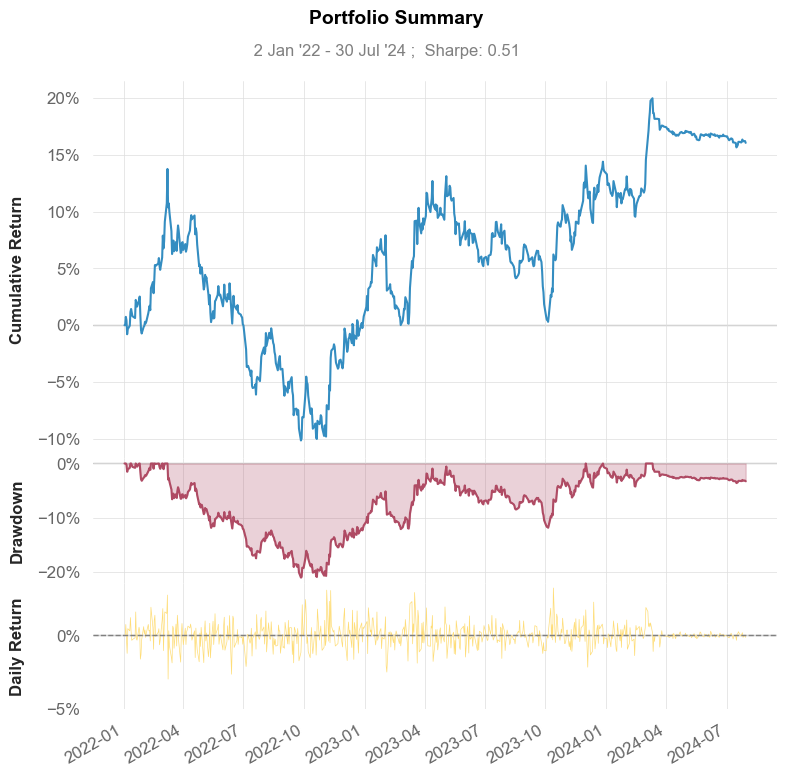

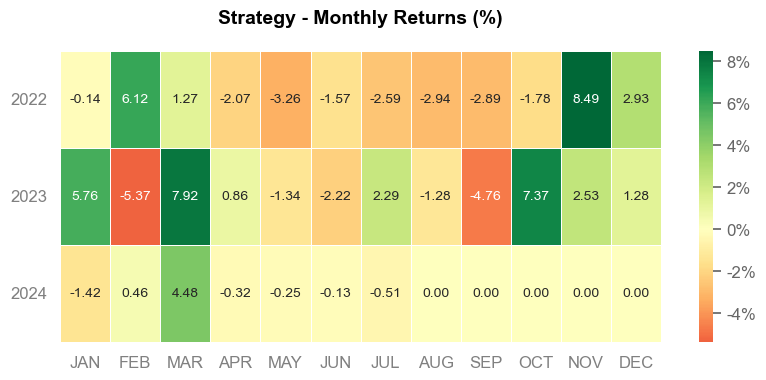

In [32]:
# Performance analysis
import quantstats as qs
# Generate a basic performance report for the equity curve
qs.reports.basic(equity_curve)

## End :)